Goal of this code is to remove H and He lines in the telluric standard

In [1]:
import astropy.units as u
import numpy as np
from math import *
from astropy.io import fits,ascii
import sys

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines
from astropy.modeling import models
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth,extract_region,FluxConservingResampler)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='serif')

The following are necessary functions

In [2]:
### Remove H or He lines in telluric ###

# spec     = spectrum to be fit
# wv1, wv2 = min, max wavelength values of region being fit
# std      = Standard deviation in pixels of Gaussian-filter used to smooth spectral line
# flag0    = Plot raw, smoothed, and corrected data of region being fit? 'Y' to do so
# flag1    = Plot raw and corrected data of entire spectrum? 'Y' to do so

### Returns Spectrum1D object of corrected spectrum ###
def LineFitting(spec,wv1,wv2,std,flag0,flag1):
    sub_region = SpectralRegion(wv1*u.AA, wv2*u.AA)
    sub_spectrum = extract_region(spec, sub_region)
    sub_spectrum_smooth = gaussian_smooth(sub_spectrum, stddev=std)
    edge=std*3
    tt = np.linspace(sub_spectrum_smooth.flux[edge].value,sub_spectrum_smooth.flux[-edge].value,len(sub_spectrum_smooth.flux[edge:-edge]))
    subflux=np.array([x.value-y.value+z for x,y,z in zip(sub_spectrum.flux[edge:-edge],sub_spectrum_smooth.flux[edge:-edge],tt)])
    sub_spectrum_corr=Spectrum1D(spectral_axis=sub_spectrum.spectral_axis[edge:-edge],flux=subflux*u.ct)
    if flag0=='Y':
        plt.figure()
        plt.step(sub_spectrum.spectral_axis,sub_spectrum.flux,'k',label='raw data') 
        plt.step(sub_spectrum_smooth.spectral_axis[edge:-edge],sub_spectrum_smooth.flux[edge:-edge],'r.',label='smoothed data') 
        plt.step(sub_spectrum_corr.spectral_axis,sub_spectrum_corr.flux,'b',label='corrected')
        plt.legend()
        plt.show()
        plt.close('all')
    # to replace the fitted part
    ind1=np.where(spec.spectral_axis==sub_spectrum_corr.spectral_axis[0])
    ind2=np.where(spec.spectral_axis==sub_spectrum_corr.spectral_axis[-1])
    flux_rep=spec.flux.value.copy()
    flux_rep[int(ind1[0]):int(ind2[0])+1]=sub_spectrum_corr.flux.value
    out_spec=Spectrum1D(spectral_axis=spec.spectral_axis,flux=flux_rep*u.ct)
    if flag1=='Y':
        plt.figure()
        plt.step(spec.spectral_axis,spec.flux,'k',label='raw data')
        plt.step(out_spec.spectral_axis,out_spec.flux,'b',label='corrected')
        plt.legend()
        plt.show()
        plt.close('all')
    spec = out_spec
    return out_spec

In [3]:
### Plot interactive spectrum to look for any H/He lines ###

# spec1,spec2   = Two spectra to compare in plot
# label1,label2 = Labels for legend in plot
# sc            = Scaling factor multiplied to spec2 to line up spectra

### USE "%matplolib inline" TO TURN OFF INTERACTIVE PLOTTING ###
def plotspec(spec1,spec2,label1,label2,sc):
    %matplotlib notebook
    plt.figure(figsize = (10,5))
    plt.plot(spec1.wavelength,spec1.flux, label = label1)
    plt.step(spec2.wavelength,spec2.flux.value*sc, label = label2)
    plt.legend()
   # plt.show()

In [4]:
# write output files
def SaveOutput(spec,outname):
    data_out={'wavelength': spec.spectral_axis,'flux': spec.flux}
    ascii.write(data_out,outname,overwrite = True)

In [5]:
### Load data from the coadded spectrum fits file from PypeIt ###

# Returns Spectrum1D object of raw spectrum #
def LoadPyPeit(filename):
    f=fits.open(filename)
    tbdata=f[1].data
    qual=tbdata['mask']
    i = np.where(qual == 1)[0]
    wv=tbdata['wave'][i]
    flux=tbdata['flux'][i]
    eflux=np.sqrt(tbdata['ivar'][i])
    spec=Spectrum1D(spectral_axis=wv*u.AA,flux=flux*u.ct)
    return spec

Calling the functions

In [6]:
# Path to telluric spectrum:
tellfile = 'exampletelluric-coadd.fits'

# Path to target spectrum for comparison to help identify H/He lines:
targfile =  'exampletarget-coadd.fits'

# Define where corrected telluric spectrum will be saved to:
outfile = 'telluric-step1.txt'   # Has to be .txt file


<IPython.core.display.Javascript object>


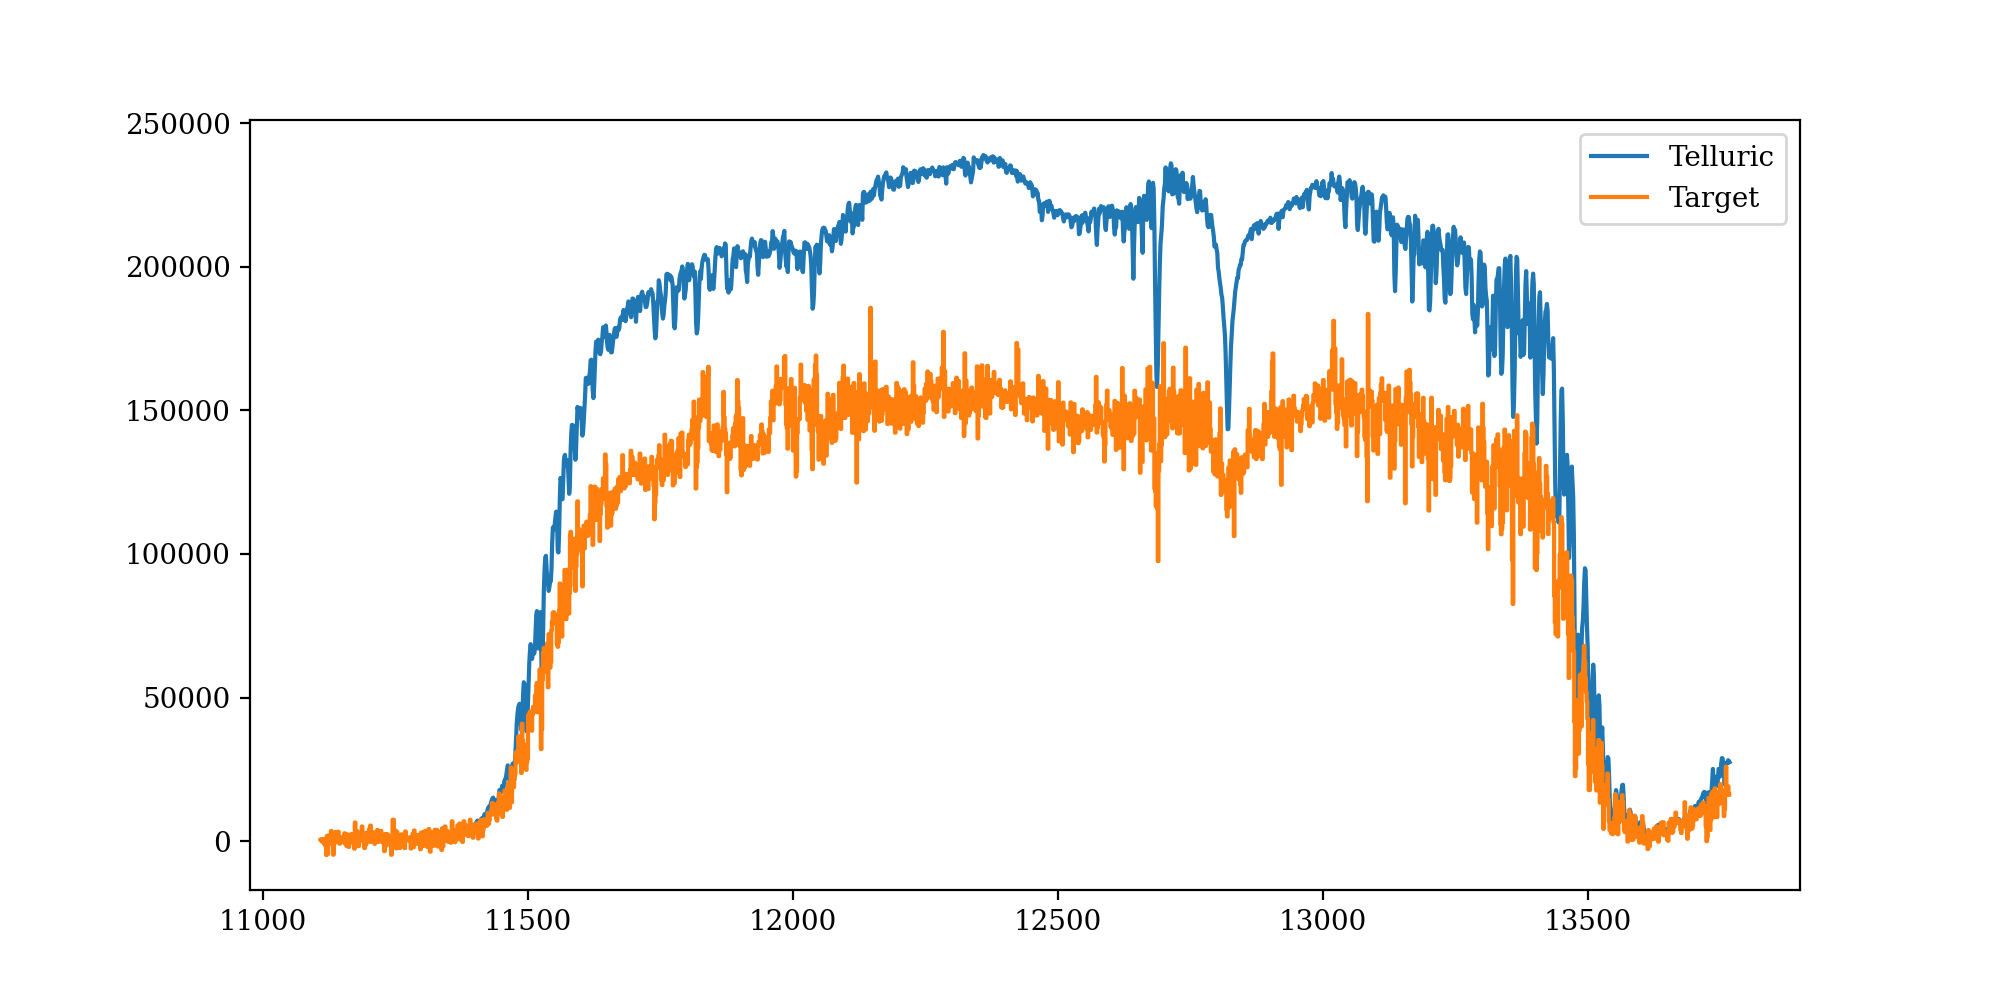

In [9]:
# Loading Files
spec_ref=LoadPyPeit(tellfile)
spec_tar=LoadPyPeit(targfile)

# Plotting telluric and target spectra on interactive plot:
plotspec(spec_ref,spec_tar,'Telluric','Target',1.7e2)

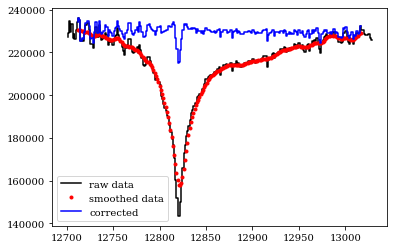

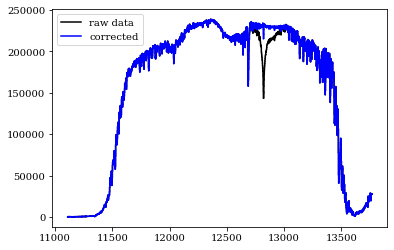

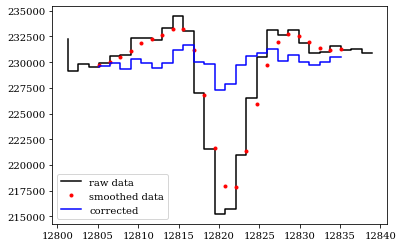

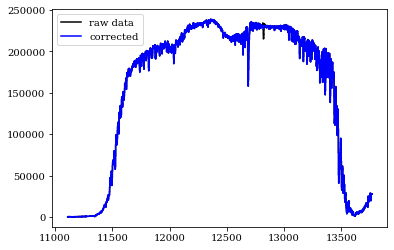

In [11]:
# Turns off interactive plotting:
%matplotlib inline 

# Paschen 5-3:
spec_ref_corr=LineFitting(spec_ref,12700,13030,3,'Y','Y')
spec_ref_corr=LineFitting(spec_ref_corr,12800,12840,1,'Y','Y')


<IPython.core.display.Javascript object>


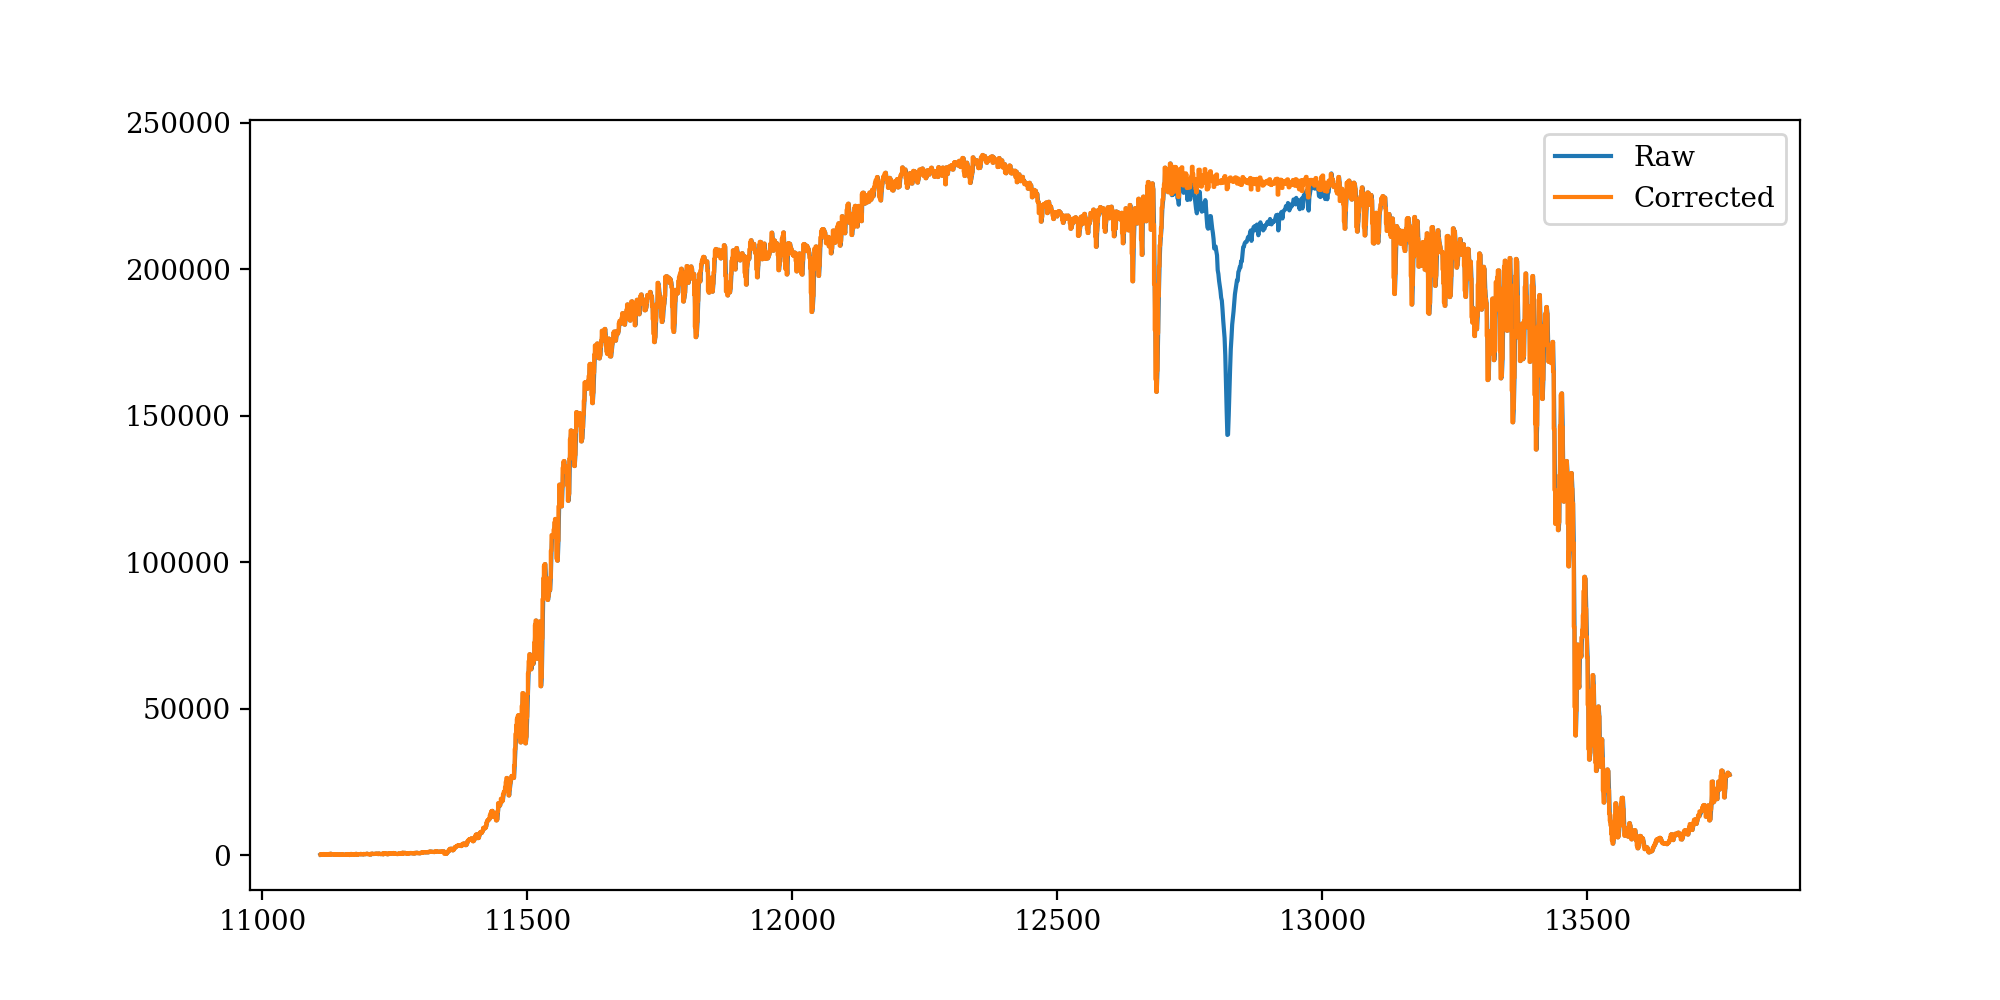

In [12]:
# Plot raw and corrected telluric to see how well lines were removed:
plotspec(spec_ref,spec_ref_corr,'Raw','Corrected',1)


In [14]:
# Save the corrected telluric spectrum
SaveOutput(spec_ref_corr,outfile)

You can copy+paste and repeat this process for each bandpass of data you have 